In [47]:
# %%
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [48]:
file_path = '../cleaned_data3.csv'

# อ่านไฟล์
df_all = pd.read_csv(file_path)
print("Raw columns:", df_all.columns.tolist())

# ทำ matching แบบไม่ขึ้นกับ case/whitespace เพื่อรองรับรูปแบบต่าง ๆ ของไฟล์
cols_norm = [c.strip().lower() for c in df_all.columns]
col_map = dict(zip(cols_norm, df_all.columns))  # normalized -> original

# ฟังก์ชันช่วยหา column จริงจากรายการชื่อที่เป็นไปได้
def find_col(candidates):
    for c in candidates:
        if c in cols_norm:
            return col_map[c]
    return None

date_col = find_col(['date_month', 'date', 'date_monthly', 'year_month'])
ind_col = find_col(['ind_code', 'indicator', 'ind', 'code', 'variable', 'name'])
val_col = find_col(['value', 'val', 'amount', 'price'])

# กรณีไฟล์เป็น long format (ต้อง pivot)
if ind_col and val_col and date_col:
    # ลบ whitespace ในรหัสตัวชี้วัด
    df_all[ind_col] = df_all[ind_col].astype(str).str.strip()
    print("Detected long format. Pivoting using:", date_col, ind_col, val_col)
    df = df_all.pivot_table(
        index=date_col,
        columns=ind_col,
        values=val_col
    ).reset_index()
    # ให้ชื่อคอลัมน์วันที่เป็น 'date_month' เพื่อความเข้ากันกับโค้ดถัดไป
    if date_col != 'date_month':
        df = df.rename(columns={date_col: 'date_month'})
else:
    # กรณีไฟล์เป็น wide format ที่มีคอลัมน์วันที่และคอลัมน์ตัวแปรอยู่แล้ว
    if date_col:
        print("Detected wide format. Using date column:", date_col)
        df = df_all.copy()
        if date_col != 'date_month':
            df = df.rename(columns={date_col: 'date_month'})
    else:
        raise KeyError("Cannot find suitable 'date' column. Available columns: " + str(df_all.columns.tolist()))

print(f"Data loaded: {df.shape}")
print(f"Columns: {sorted(df.columns.tolist())}\n")

# เตรียมข้อมูลเวลา
df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)
df = df.set_index(['date_month'])
df = df.asfreq('MS')  # Monthly Start

print("Data preparation completed\n")
df.info()

# Train / Test split
test_size = 18
train_data = df[:-test_size]
test_data = df[-test_size:]

print("\nTrain data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

df.head()


Raw columns: ['year_month', 'domestic_consumption', 'import_volume', 'export_volume', 'stock', 'exchange_rate_usd', 'china_pmi', 'thai_price', 'oil_price_thb', 'world_price_thb_kg', 'month', 'quarter', 'year', 'is_season', 'thai_price_lag6', 'thai_price_lag12', 'world_price_thb_kg_lag6', 'world_price_thb_kg_lag12', 'oil_price_thb_lag6', 'oil_price_thb_lag12', 'china_pmi_lag6', 'china_pmi_lag12', 'stock_lag6', 'stock_lag12', 'thai_price_ma6', 'thai_price_std6', 'thai_price_ma12', 'thai_price_std12', 'world_price_thb_kg_ma6', 'world_price_thb_kg_std6', 'world_price_thb_kg_ma12', 'world_price_thb_kg_std12', 'oil_price_thb_ma6', 'oil_price_thb_std6', 'oil_price_thb_ma12', 'oil_price_thb_std12', 'china_pmi_ma6', 'china_pmi_std6', 'china_pmi_ma12', 'china_pmi_std12', 'thai_price_pct6', 'thai_price_pct12', 'world_price_thb_kg_pct6', 'world_price_thb_kg_pct12', 'oil_price_thb_pct6', 'oil_price_thb_pct12', 'exchange_rate_usd_pct6', 'exchange_rate_usd_pct12']
Detected wide format. Using date col

C:\Users\bankw\AppData\Local\Temp\ipykernel_11608\2582047331.py:49: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)


,domestic_consumption,import_volume,export_volume,stock,exchange_rate_usd,china_pmi,thai_price,oil_price_thb,world_price_thb_kg,month,...,china_pmi_ma12,china_pmi_std12,thai_price_pct6,thai_price_pct12,world_price_thb_kg_pct6,world_price_thb_kg_pct12,oil_price_thb_pct6,oil_price_thb_pct12,exchange_rate_usd_pct6,exchange_rate_usd_pct12
date_month,,,,,,,,,,,,,,,,,,,,,
2007-01-01,30652000,55000,267567000.0,280671000.0,36.18,54.8,65.12,2103.5052,75.168260,1,...,54.991667,1.568704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-02-01,26790000,44000,237979000.0,249005000.0,35.75,55.1,72.91,2208.9925,81.465325,2,...,54.991667,1.568704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-03-01,31717000,119000,230410000.0,217339000.0,35.06,53.1,69.62,2309.4022,78.626062,3,...,54.991667,1.568704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-04-01,27788000,184000,180185000.0,178575000.0,34.87,56.1,72.84,2291.3077,80.907121,4,...,54.991667,1.568704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-05-01,32905000,91000,178103000.0,209215000.0,34.62,58.6,71.47,2216.0262,82.004049,5,...,54.991667,1.568704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


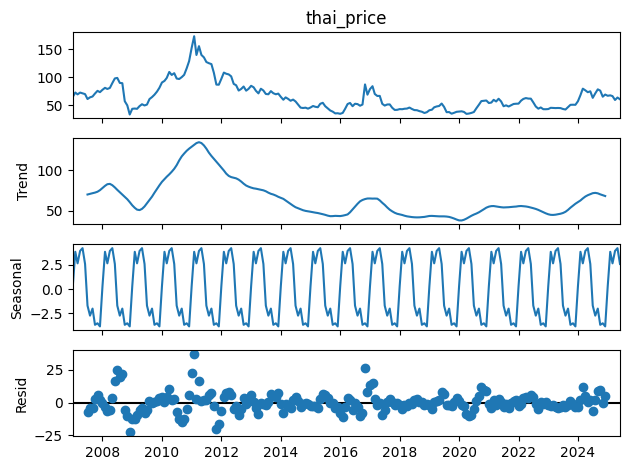

In [49]:
# %%
# Try to find the target series for decomposition (fallbacks if 'TRP' not present)
candidates = ['trp', 'thai_rubber_price', 'thai_price', 'rubber_price', 'price']
chosen = None

# direct exact match first
if 'TRP' in df.columns:
	chosen = 'TRP'

# try helper find_col (defined in an earlier cell) or case-insensitive search
if chosen is None:
	try:
		chosen = find_col(candidates)
	except NameError:
		cols_norm = [c.strip().lower() for c in df.columns]
		for cand in candidates:
			if cand in cols_norm:
				chosen = df.columns[cols_norm.index(cand)]
				break

if chosen is None:
	raise KeyError(f"Cannot find target series for seasonal_decompose. Available columns: {df.columns.tolist()}")

# perform decomposition on the selected series (drop NA)
series = df[chosen].dropna()
result = seasonal_decompose(series, model='additive', period=12)
result.plot()
plt.show()


Available factors: ['domestic_consumption', 'import_volume', 'export_volume', 'stock', 'exchange_rate_usd', 'china_pmi', 'thai_price', 'oil_price_thb', 'world_price_thb_kg', 'month', 'quarter', 'year', 'is_season', 'thai_price_lag6', 'thai_price_lag12', 'world_price_thb_kg_lag6', 'world_price_thb_kg_lag12', 'oil_price_thb_lag6', 'oil_price_thb_lag12', 'china_pmi_lag6', 'china_pmi_lag12', 'stock_lag6', 'stock_lag12', 'thai_price_ma6', 'thai_price_std6', 'thai_price_ma12', 'thai_price_std12', 'world_price_thb_kg_ma6', 'world_price_thb_kg_std6', 'world_price_thb_kg_ma12', 'world_price_thb_kg_std12', 'oil_price_thb_ma6', 'oil_price_thb_std6', 'oil_price_thb_ma12', 'oil_price_thb_std12', 'china_pmi_ma6', 'china_pmi_std6', 'china_pmi_ma12', 'china_pmi_std12', 'thai_price_pct6', 'thai_price_pct12', 'world_price_thb_kg_pct6', 'world_price_thb_kg_pct12', 'oil_price_thb_pct6', 'oil_price_thb_pct12', 'exchange_rate_usd_pct6', 'exchange_rate_usd_pct12']
Selected factors: ['world_price_thb_kg', 'th

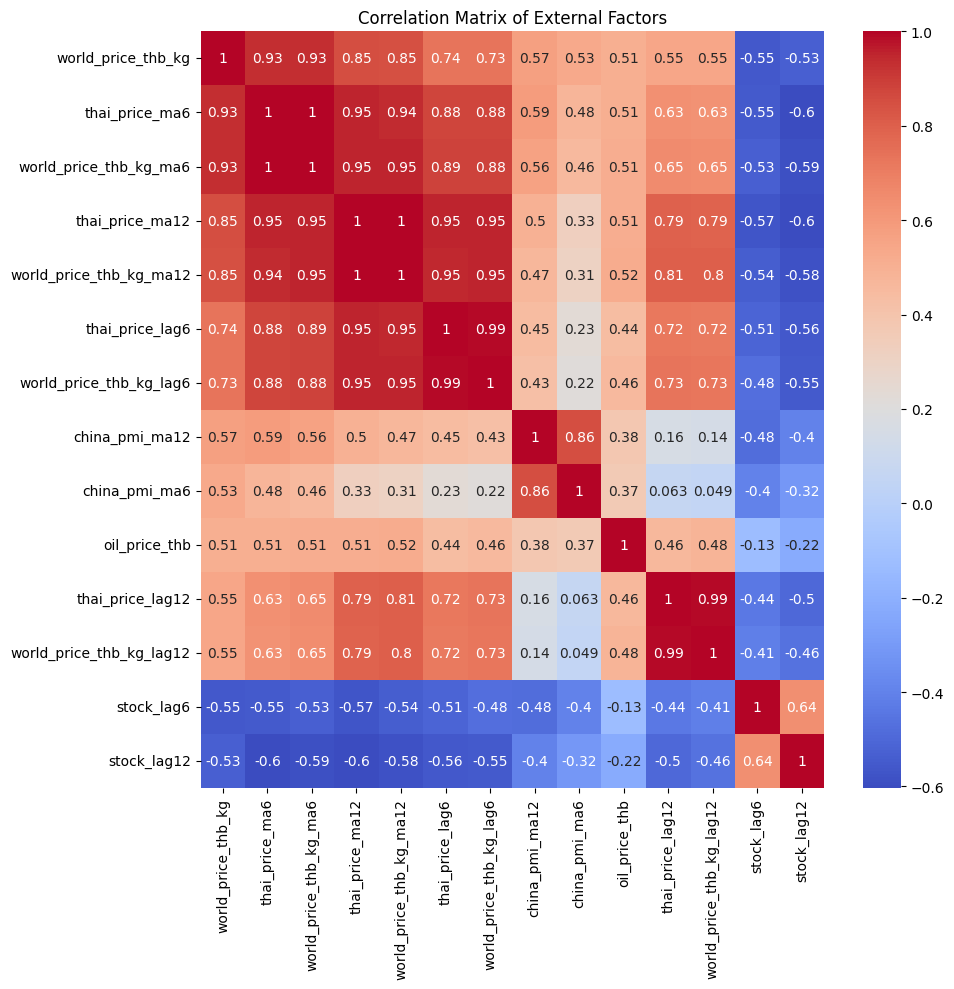

world_price_thb_kg: ADF Statistic = -2.4895, p-value = 0.1180
thai_price_ma6: ADF Statistic = -1.4995, p-value = 0.5338
world_price_thb_kg_ma6: ADF Statistic = -1.6690, p-value = 0.4472
thai_price_ma12: ADF Statistic = -1.6441, p-value = 0.4601
world_price_thb_kg_ma12: ADF Statistic = -1.8910, p-value = 0.3363
thai_price_lag6: ADF Statistic = -2.3107, p-value = 0.1685
world_price_thb_kg_lag6: ADF Statistic = -2.4780, p-value = 0.1209
china_pmi_ma12: ADF Statistic = -3.3681, p-value = 0.0121
china_pmi_ma6: ADF Statistic = -3.3365, p-value = 0.0133
oil_price_thb: ADF Statistic = -2.9920, p-value = 0.0356
thai_price_lag12: ADF Statistic = -2.3128, p-value = 0.1679
world_price_thb_kg_lag12: ADF Statistic = -2.4959, p-value = 0.1165
stock_lag6: ADF Statistic = -0.8204, p-value = 0.8131
stock_lag12: ADF Statistic = -1.2076, p-value = 0.6703


In [ ]:
# %%
external_factors = ['domestic_consumption',
                    'stock',
                    'exchange_rate_usd',
                    'china_pmi',
                    'oil_price_thb',
                    'year',
                    'thai_price_ma3',
                    'thai_price_std3',
                    'thai_price_ma6',
                    'thai_price_std6',
                    'thai_price_ma12',
                    'world_price_thb_kg_ma3',
                    'world_price_thb_kg_std3',
                    'world_price_thb_kg_ma6',
                    'world_price_thb_kg_std6',
                    'world_price_thb_kg_ma12',
                    'oil_price_thb_std3',
                    'oil_price_thb_ma6',
                    'oil_price_thb_std12',
                    'china_pmi_ma3',
                    'china_pmi_std6',
                    'china_pmi_ma12',
                    'thai_price_pct1',
                    'thai_price_pct3',
                    'thai_price_pct6',
                    'thai_price_pct12',
                    'world_price_thb_kg_pct1',
                    'world_price_thb_kg_pct3',
                    'world_price_thb_kg_pct6',
                    'oil_price_thb_pct3',
                    'oil_price_thb_pct6',
                    'exchange_rate_usd_pct6',
                    'exchange_rate_usd_pct12',
                    'net_export',
                    'stock_consumption_ratio',
                    'thai_price_lag1',
                    'thai_price_lag3',
                    'thai_price_lag6',
                    'thai_price_lag12',
                    'world_price_thb_kg_lag1',
                    'world_price_thb_kg_lag3',
                    'world_price_thb_kg_lag6',
                    'oil_price_thb_lag1',
                    'oil_price_thb_lag6',
                    'china_pmi_lag12',
                    'stock_lag1',
                    'stock_lag3',
                    'stock_lag6',
                    'exchange_rate_usd_lag1',
                    'exchange_rate_usd_lag12',
                    'net_export_lag12',
                    'production_growth_lag3',]

print("Available factors:", df.columns.tolist())
print("Selected factors:", [f for f in external_factors if f in df.columns])
print()

# เตรียม exogenous variables
train_exog = train_data[external_factors].copy()
test_exog = test_data[external_factors].copy()

print(f"Train exogenous shape: {train_exog.shape}")
print(f"Test exogenous shape: {test_exog.shape}\n")

# Heatmap correlation
correlation_matrix = train_data[external_factors].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of External Factors")
plt.tight_layout()
plt.show()

# ตรวจ stationarity ของแต่ละตัวแปร
for col in external_factors:
    result_adf = adfuller(train_data[col].dropna())
    print(f"{col}: ADF Statistic = {result_adf[0]:.4f}, p-value = {result_adf[1]:.4f}")


In [51]:
print([v for v in dir() if not v.startswith("_")])


['In', 'Out', 'PCA', 'SARIMAX', 'SARIMAXResults', 'StandardScaler', 'TARGET_COL', 'accuracy_arima', 'accuracy_before', 'adfuller', 'all_approaches', 'approach1_results', 'approach2_results', 'auto_arima', 'ax', 'ax0', 'axes', 'best1', 'best2', 'best_overall', 'candidates', 'chosen', 'coef_summary', 'col', 'col_map', 'colors', 'cols_norm', 'comparison_df', 'correlation_matrix', 'data', 'date_col', 'datetime', 'df', 'df_all', 'df_comparison', 'df_display', 'exit', 'exp_vars', 'explained_var', 'external_factors', 'fac', 'factor', 'fig', 'file_path', 'find_col', 'get_ipython', 'i', 'ind_col', 'key_factor_combinations', 'key_factors', 'kf', 'mape', 'mape_arima', 'mape_before', 'mapes', 'mask', 'mask_test', 'mask_train', 'mean_absolute_percentage_error', 'mean_squared_error', 'methods', 'missing', 'model_auto', 'model_auto_arima', 'model_order', 'model_seasonal_order', 'n_comp', 'n_pca', 'n_plots', 'name', 'np', 'num_factors', 'open', 'other_factors', 'other_pca', 'other_pca_test', 'other_sc

model order: (0, 1, 0)
seasonal order: (0, 1, 1, 12)

After cleaning:
Train exog shape: (204, 14)
Test exog shape : (18, 14)
y_train shape   : (204,)
y_test shape    : (18,)


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



SARIMAX fitted summary (Baseline):
                                      SARIMAX Results                                       
Dep. Variable:                           thai_price   No. Observations:                  204
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -474.102
Date:                              Thu, 27 Nov 2025   AIC                            980.204
Time:                                      01:34:57   BIC                           1031.113
Sample:                                  01-01-2007   HQIC                          1000.849
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
world_price_thb_kg           0.901

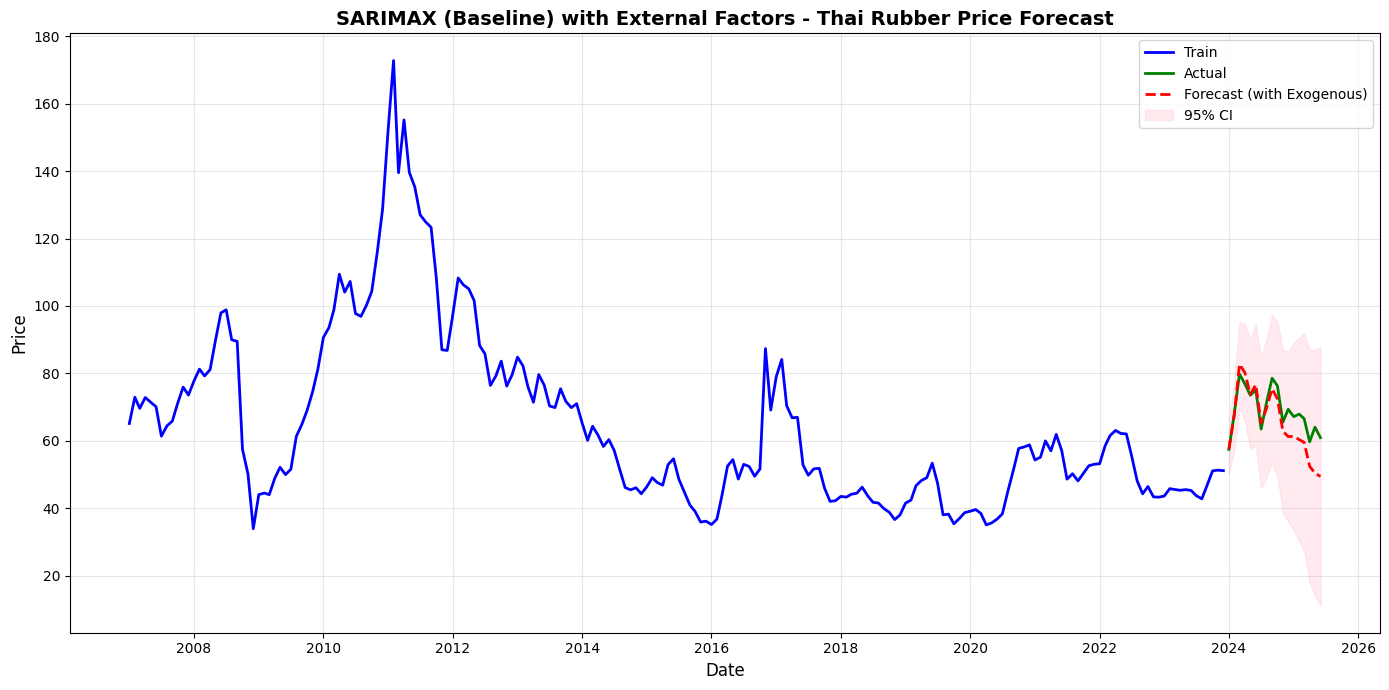

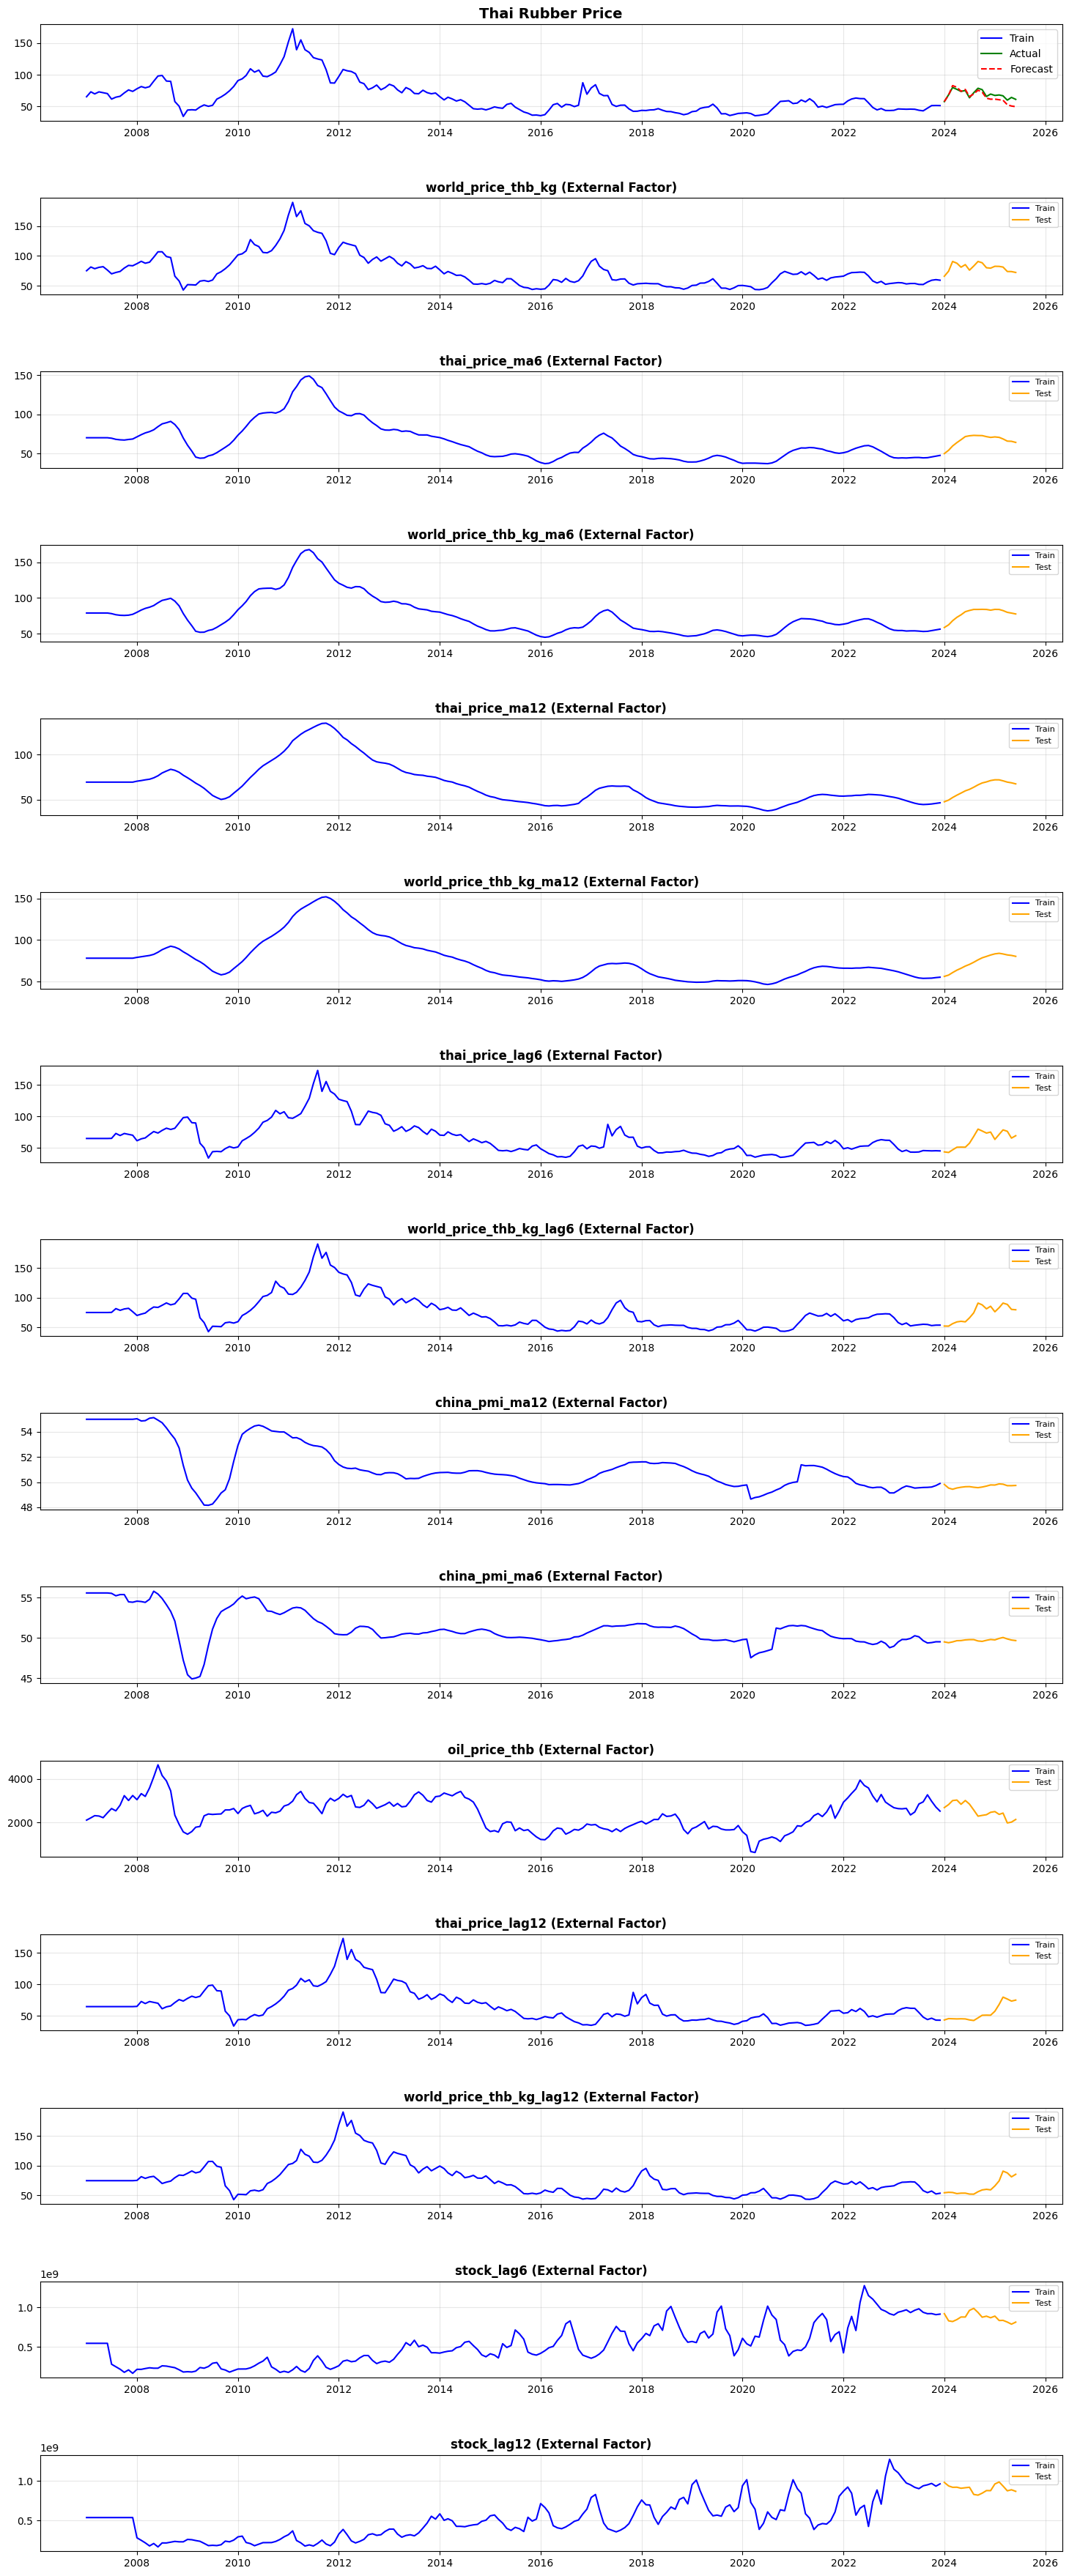

In [53]:
# %%
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

TARGET_COL = 'thai_price'   # ถ้า column จริงชื่อ TRP ให้เปลี่ยนเป็น 'TRP'

seasonal_period = 12
model_order = (0, 1, 0)
model_seasonal_order = (0, 1, 1, seasonal_period)

print(f"model order: {model_order}")
print(f"seasonal order: {model_seasonal_order}")

# --- 1) ทำความสะอาด exog และ align กับ y ---

# ลบ inf แล้วแทนเป็น NaN ก่อน
train_exog_clean = train_exog.replace([np.inf, -np.inf], np.nan)
test_exog_clean  = test_exog.replace([np.inf, -np.inf], np.nan)

# mask แถวที่ทุก factor ไม่ NaN และ y ไม่ NaN
mask_train = train_exog_clean.notna().all(axis=1) & train_data[TARGET_COL].notna()
mask_test  = test_exog_clean.notna().all(axis=1) & test_data[TARGET_COL].notna()

train_exog_clean = train_exog_clean.loc[mask_train]
test_exog_clean  = test_exog_clean.loc[mask_test]

y_train = train_data.loc[mask_train, TARGET_COL]
y_test  = test_data.loc[mask_test, TARGET_COL]

print("\nAfter cleaning:")
print("Train exog shape:", train_exog_clean.shape)
print("Test exog shape :", test_exog_clean.shape)
print("y_train shape   :", y_train.shape)
print("y_test shape    :", y_test.shape)

# --- 2) Fit SARIMAX ---

sarimax_model = SARIMAX(
    y_train,
    exog=train_exog_clean,
    order=model_order,
    seasonal_order=model_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_results = sarimax_model.fit(disp=False)
print("\nSARIMAX fitted summary (Baseline):")
print(sarimax_results.summary())
print()

# --- 3) Predict บนช่วง test (ใช้ index ของ test ที่สะอาดแล้ว) ---

pred_results = sarimax_results.get_prediction(
    start=test_exog_clean.index[0],
    end=test_exog_clean.index[-1],
    exog=test_exog_clean,
    dynamic=False
)

pred_mean = pred_results.predicted_mean
pred_ci   = pred_results.conf_int()

# --- 4) ประเมินผล Baseline ---

rmse_before = np.sqrt(mean_squared_error(y_test, pred_mean))
mape_before = mean_absolute_percentage_error(y_test, pred_mean)
accuracy_before = 1 - mape_before

print(f"Test RMSE (Baseline): {rmse_before:.4f}")
print(f"Test MAPE (Baseline): {mape_before*100:.2f}%")
print(f"Test Accuracy (Baseline): {accuracy_before*100:.2f}%\n")

# --- 5) วิเคราะห์ coef ของ external factors ---

print("External Factors Impact on Thai Rubber Price (Baseline):")
coef_summary = pd.DataFrame({
    'Factor': external_factors,
    'Coefficient': sarimax_results.params[
        [f'exog.{i}' if f'exog.{i}' in sarimax_results.params.index 
         else external_factors[i] for i in range(len(external_factors))]
    ],
})
print(coef_summary)
print()

# --- 6) Plot Forecast (ใช้ test_data_clean ตาม mask_test) ---

test_data_clean = test_data.loc[mask_test]

plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data[TARGET_COL], label='Train', color='blue', linewidth=2)
plt.plot(test_data_clean.index, test_data_clean[TARGET_COL], label='Actual', color='green', linewidth=2)
plt.plot(test_data_clean.index, pred_mean, label='Forecast (with Exogenous)', 
         color='red', linewidth=2, linestyle='--')

plt.fill_between(test_data_clean.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% CI')

plt.title('SARIMAX (Baseline) with External Factors - Thai Rubber Price Forecast', 
          fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- 7) Subplot External Factors (หน้าตาใหม่) ---

n_plots = len(external_factors) + 1

fig, axes = plt.subplots(
    n_plots, 1,
    figsize=(18, n_plots * 2.5)
)

# Main series
axes[0].plot(train_data.index, train_data[TARGET_COL], label='Train', color='blue')
axes[0].plot(test_data_clean.index, test_data_clean[TARGET_COL], label='Actual', color='green')
axes[0].plot(test_data_clean.index, pred_mean, label='Forecast', color='red', linestyle='--')
axes[0].set_title('Thai Rubber Price', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# External factors
for i, factor in enumerate(external_factors):
    ax = axes[i+1]
    ax.plot(train_data.index, train_data[factor], label='Train', color='blue')
    ax.plot(test_data.index, test_data[factor], label='Test', color='orange')
    ax.set_title(f'{factor} (External Factor)', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

fig.subplots_adjust(hspace=0.8, top=0.96, bottom=0.04)
plt.show()


Available factors: ['domestic_consumption', 'import_volume', 'export_volume', 'stock', 'exchange_rate_usd', 'china_pmi', 'thai_price', 'oil_price_thb', 'world_price_thb_kg', 'month', 'quarter', 'year', 'is_season', 'thai_price_lag6', 'thai_price_lag12', 'world_price_thb_kg_lag6', 'world_price_thb_kg_lag12', 'oil_price_thb_lag6', 'oil_price_thb_lag12', 'china_pmi_lag6', 'china_pmi_lag12', 'stock_lag6', 'stock_lag12', 'thai_price_ma6', 'thai_price_std6', 'thai_price_ma12', 'thai_price_std12', 'world_price_thb_kg_ma6', 'world_price_thb_kg_std6', 'world_price_thb_kg_ma12', 'world_price_thb_kg_std12', 'oil_price_thb_ma6', 'oil_price_thb_std6', 'oil_price_thb_ma12', 'oil_price_thb_std12', 'china_pmi_ma6', 'china_pmi_std6', 'china_pmi_ma12', 'china_pmi_std12', 'thai_price_pct6', 'thai_price_pct12', 'world_price_thb_kg_pct6', 'world_price_thb_kg_pct12', 'oil_price_thb_pct6', 'oil_price_thb_pct12', 'exchange_rate_usd_pct6', 'exchange_rate_usd_pct12']
Selected factors: ['world_price_thb_kg', 'th

c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                         thai_price   No. Observations:                  204
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -446.212
Date:                            Thu, 27 Nov 2025   AIC                            926.424
Time:                                    01:35:05   BIC                            979.430
Sample:                                01-01-2007   HQIC                           947.938
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
world_price_thb_kg           0.9011      0.053     17.020      0.000       0.797      

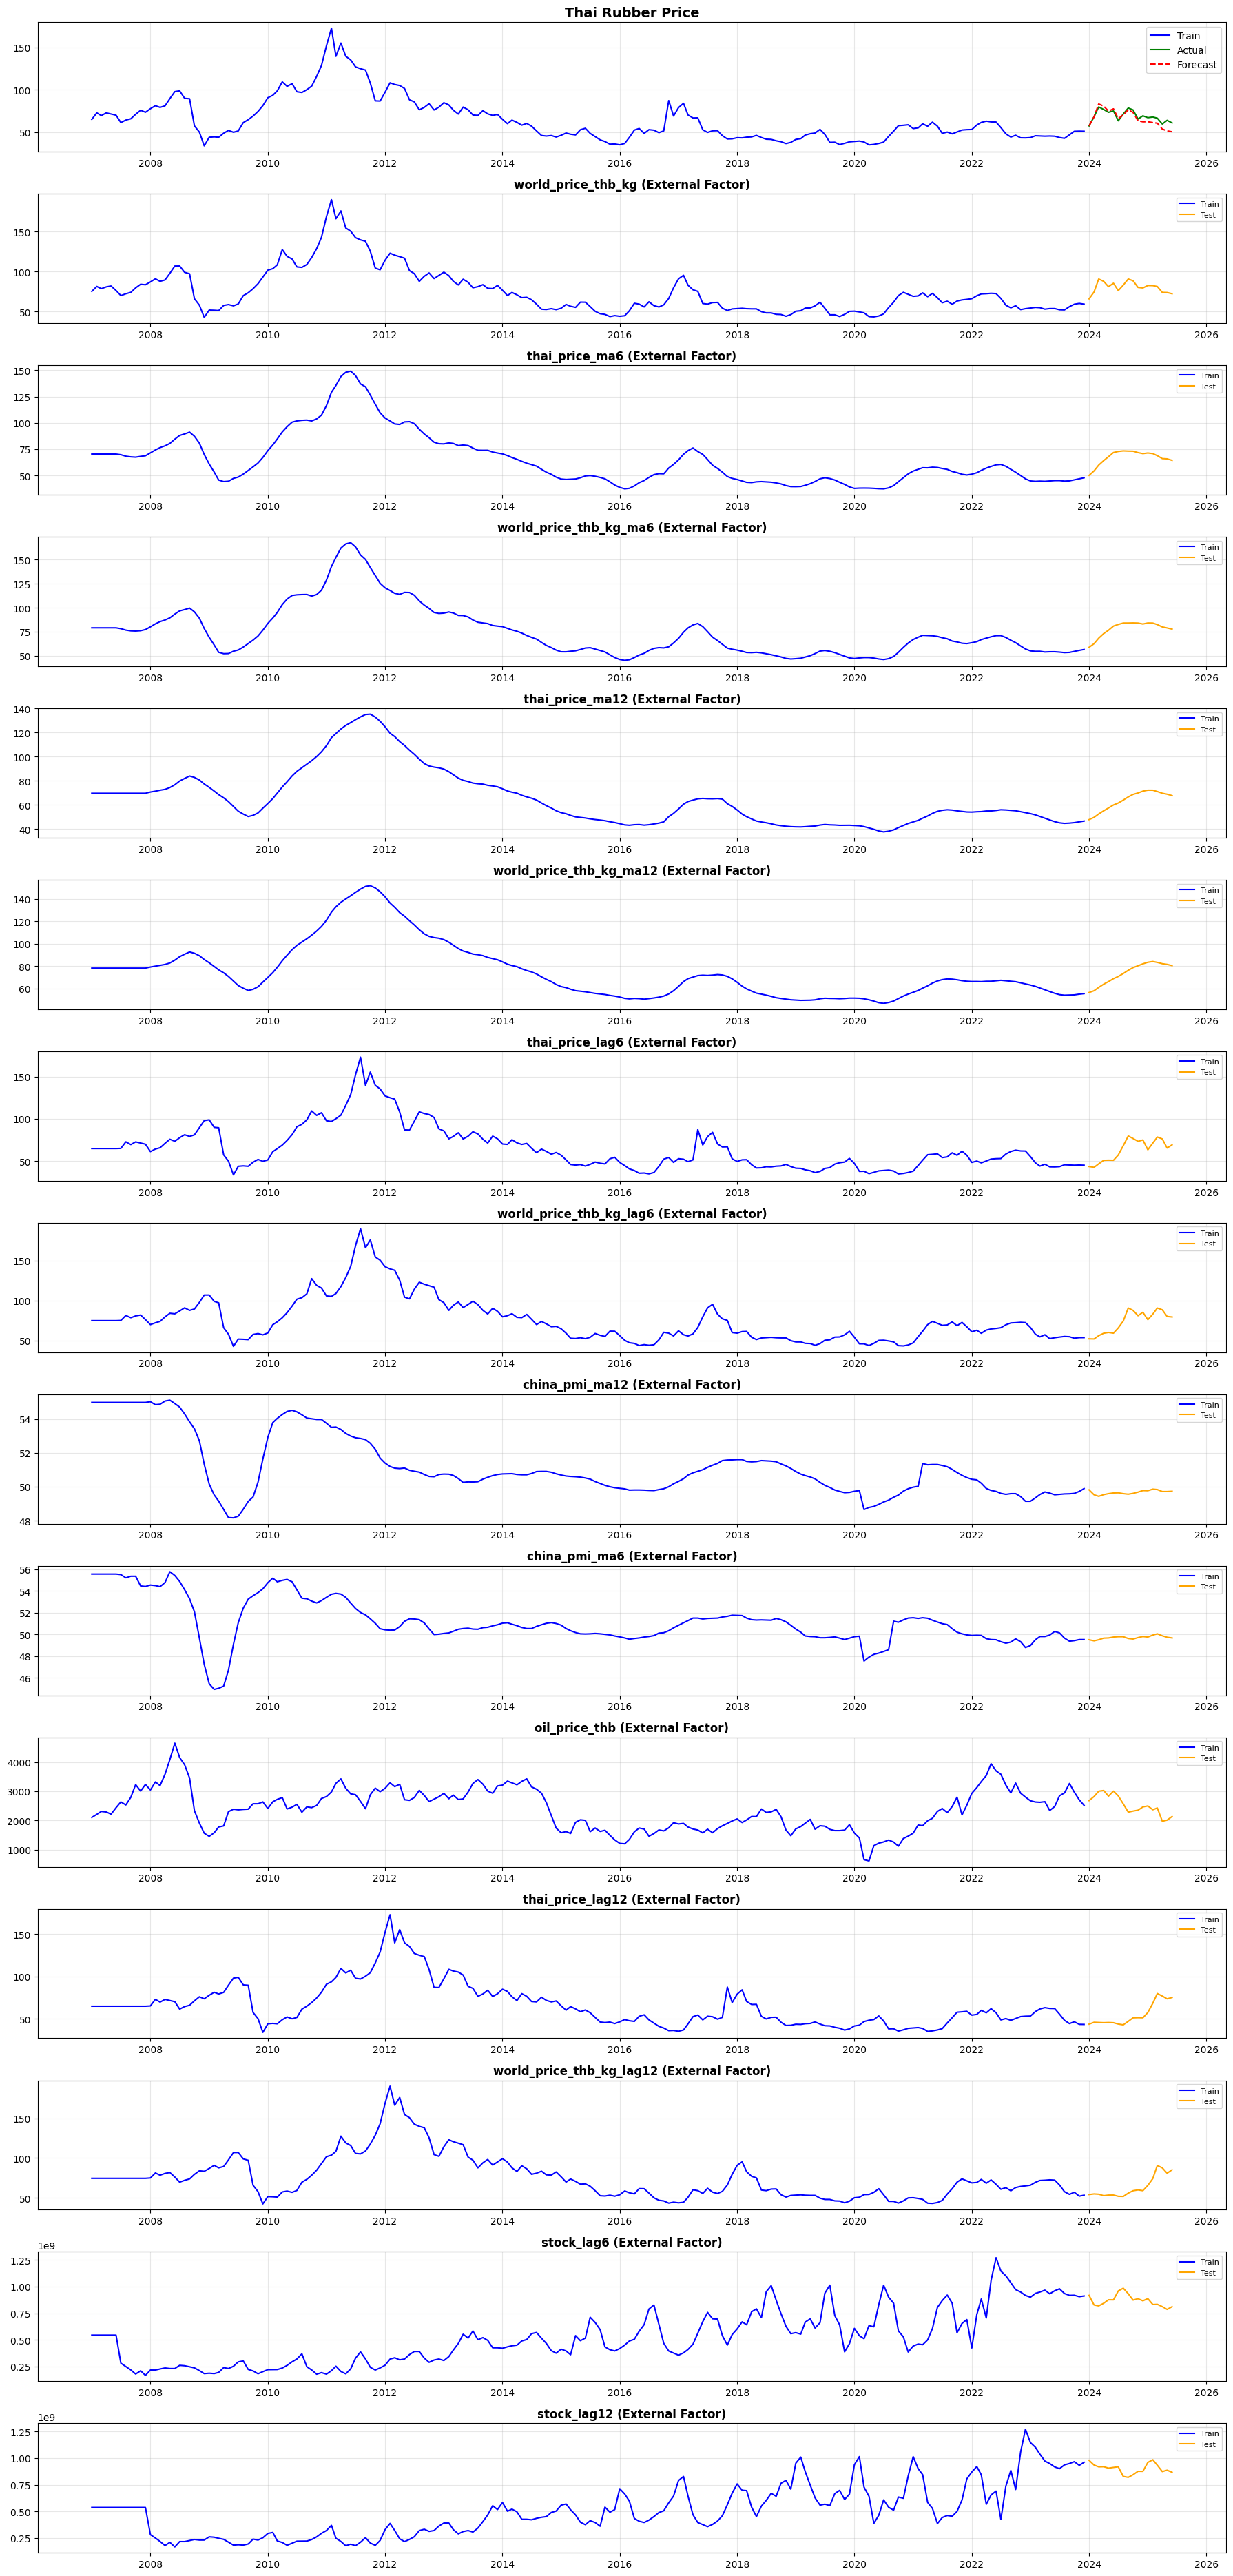

In [54]:

external_factors = ['world_price_thb_kg', 'thai_price_ma6', 'world_price_thb_kg_ma6', 'thai_price_ma12', 'world_price_thb_kg_ma12', 'thai_price_lag6', 'world_price_thb_kg_lag6',
    'china_pmi_ma12', 'china_pmi_ma6', 'oil_price_thb', 'thai_price_lag12', 'world_price_thb_kg_lag12', 'stock_lag6', 'stock_lag12']

# Define train_endog to match the cleaned exogenous data
train_endog = train_data.loc[train_exog_clean.index, 'thai_price']

print("Available factors:", train_data.columns.tolist())
print("Selected factors:", [f for f in external_factors if f in train_data.columns])
print()

# เตรียม exogenous variables (cleaned / imputed) — ต้องแน่ใจว่าไม่มี NaN หรือ inf ใน exog ก่อนใช้งานกับ auto_arima / SARIMAX
train_exog = train_data[external_factors].copy()
test_exog = test_data[external_factors].copy()

# รวม endog กับ exog เพื่อจัดการ missing values ให้สอดคล้องกันสำหรับการ train
train_df = pd.concat([train_data['thai_price'], train_exog], axis=1)

# ตรวจสอบและลบ missing values จาก train_endog และ train_exog_clean พร้อมกัน
train_endog_aligned, train_exog_aligned = train_endog.align(train_exog_clean, join='inner')
mask = (~train_endog_aligned.isna()) & (~train_exog_aligned.isna().any(axis=1))
train_endog_fit = train_endog_aligned[mask]
train_exog_fit = train_exog_aligned[mask]

# ใช้ auto_arima หาพารามิเตอร์ที่ดีที่สุด พร้อม exogenous variables (ใช้ train_endog และ train_exog_clean ที่ไม่มี NaN)
seasonal_period = 12

model_auto_arima = auto_arima(
    train_endog_fit,
    exogenous=train_exog_fit,
    start_p=1, start_q=1,
    max_p=3, max_q=3,
    m=seasonal_period,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    d=1, D=1,
    seasonal=True,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
)

model_order = model_auto_arima.order
model_seasonal_order = model_auto_arima.seasonal_order

print(f"model order (Auto ARIMA): {model_order}")
print(f"seasonal order (Auto ARIMA): {model_seasonal_order}")

# SARIMAX model พร้อม exogenous variables (ใช้ตัวแปร cleaned)
# ใช้ start = len(train_endog) เพราะเราอาจจะ drop แถวบางส่วนของ train ในการ clean exog
pred_results = sarimax_results.get_prediction(
    start=len(train_endog),
    end=len(train_endog) + len(test_exog_clean) - 1,
    exog=test_exog_clean,
    dynamic=False
)

pred_mean = pred_results.predicted_mean
pred_ci = pred_results.conf_int()
sarimax_model = SARIMAX(
    train_endog_fit,
    exog=train_exog_fit,
    order=model_order,
    seasonal_order=model_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_results = sarimax_model.fit(disp=False)
print(sarimax_results.summary())
print()

pred_results = sarimax_results.get_prediction(
    start=len(train_endog_fit),
    end=len(train_endog_fit) + len(test_exog_clean) - 1,
    exog=test_exog_clean, 
    dynamic=False
)

pred_mean = pred_results.predicted_mean
pred_ci = pred_results.conf_int()

# ประเมินผล Auto ARIMA
rmse_arima = np.sqrt(mean_squared_error(test_data['thai_price'], pred_mean))
mape_arima = mean_absolute_percentage_error(test_data['thai_price'], pred_mean)
accuracy_arima = 1 - mape_arima

print(f"Test RMSE (Auto ARIMA): {rmse_arima:.4f}")
print(f"Test MAPE (Auto ARIMA): {mape_arima*100:.2f}%")
print(f"Test Accuracy (Auto ARIMA): {accuracy_arima*100:.2f}%\n")

# วิเคราะห์ coef ของ external factors
print("External Factors Impact on Thai Rubber Price (Auto ARIMA):")
coef_summary = pd.DataFrame({
    'Factor': external_factors,
    'Coefficient': sarimax_results.params[[f'exog.{i}' if f'exog.{i}' in sarimax_results.params.index 
                                          else external_factors[i] for i in range(len(external_factors))]],
})
print(coef_summary)
print()

# ===== Subplot External Factors (Auto ARIMA เวอร์ชันใหม่) =====
n_plots = len(external_factors) + 1

fig, axes = plt.subplots(
    n_plots, 1,
    figsize=(18, n_plots * 2.5)
)

# Main series
axes[0].plot(train_endog.index, train_endog, label='Train', color='blue')
axes[0].plot(test_data.index, test_data['thai_price'], label='Actual', color='green')
axes[0].plot(test_data.index, pred_mean, label='Forecast', color='red', linestyle='--')
axes[0].set_title('Thai Rubber Price', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# External factors
for i, factor in enumerate(external_factors):
    ax = axes[i+1]
    ax.plot(train_exog_clean.index, train_exog_clean[factor], label='Train', color='blue')
    ax.plot(test_exog_clean.index, test_exog_clean[factor], label='Test', color='orange')
    ax.set_title(f'{factor} (External Factor)', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Available factors in df: ['domestic_consumption', 'import_volume', 'export_volume', 'stock', 'exchange_rate_usd', 'china_pmi', 'thai_price', 'oil_price_thb', 'world_price_thb_kg', 'month', 'quarter', 'year', 'is_season', 'thai_price_lag6', 'thai_price_lag12', 'world_price_thb_kg_lag6', 'world_price_thb_kg_lag12', 'oil_price_thb_lag6', 'oil_price_thb_lag12', 'china_pmi_lag6', 'china_pmi_lag12', 'stock_lag6', 'stock_lag12', 'thai_price_ma6', 'thai_price_std6', 'thai_price_ma12', 'thai_price_std12', 'world_price_thb_kg_ma6', 'world_price_thb_kg_std6', 'world_price_thb_kg_ma12', 'world_price_thb_kg_std12', 'oil_price_thb_ma6', 'oil_price_thb_std6', 'oil_price_thb_ma12', 'oil_price_thb_std12', 'china_pmi_ma6', 'china_pmi_std6', 'china_pmi_ma12', 'china_pmi_std12', 'thai_price_pct6', 'thai_price_pct12', 'world_price_thb_kg_pct6', 'world_price_thb_kg_pct12', 'oil_price_thb_pct6', 'oil_price_thb_pct12', 'exchange_rate_usd_pct6', 'exchange_rate_usd_pct12']
Selected factors: ['world_price_thb_kg

c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  RMSE: 15.8267, MAPE: 21.40%, AIC: 1056.01

9 Components: Explained Variance = 99.79%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  RMSE: 5.2693, MAPE: 6.69%, AIC: 977.01

Summary (PCA only):
 Components Explained Var      RMSE   MAPE         AIC
          2         78.9%  9.901690 11.95% 1151.611898
          3         86.3%  9.950084 10.82% 1146.923561
          4         91.4%  8.371258 10.24% 1144.496342
          5         94.3%  8.759262 11.18% 1145.991808
          6         96.8% 14.925270 20.29% 1066.874833
          7         98.9% 15.554703 21.01% 1054.073279
          8         99.5% 15.826662 21.40% 1056.005393
          9         99.8%  5.269286  6.69%  977.008659

Best PCA-only: 9 components
Explained Variance: 99.79%
RMSE: 5.2693
MAPE: 6.69%


Hybrid Approach (Key Factors + PCA)

Testing: World price only
Key factors: ['world_price_thb_kg']
PCA factors: ['thai_price_ma6', 'world_price_thb_kg_ma6', 'thai_price_ma12', 'world_price_thb_kg_ma12', 'thai_price_lag6', 'world_price_thb_kg_lag6', 'china_pmi_ma12', 'china_pmi_ma6', 'oil_price_thb', 'thai_price_lag12', 'world_price_thb_kg_lag12', 'stock_lag6

c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 key + 3 PCA = 5 total
PCA explains 89.9% of other factors
RMSE: 5.2748, MAPE: 6.77%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 key + 4 PCA = 6 total
PCA explains 94.4% of other factors
RMSE: 5.0533, MAPE: 6.47%

Testing: World price + Stock
Key factors: ['world_price_thb_kg', 'stock_lag6']
PCA factors: ['thai_price_ma6', 'world_price_thb_kg_ma6', 'thai_price_ma12', 'world_price_thb_kg_ma12', 'thai_price_lag6', 'world_price_thb_kg_lag6', 'china_pmi_ma12', 'china_pmi_ma6', 'oil_price_thb', 'thai_price_lag12', 'world_price_thb_kg_lag12', 'stock_lag12']


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 key + 2 PCA = 4 total
PCA explains 82.0% of other factors
RMSE: 2.3113, MAPE: 2.84%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 key + 3 PCA = 5 total
PCA explains 88.9% of other factors
RMSE: 2.5356, MAPE: 3.18%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 key + 4 PCA = 6 total
PCA explains 94.0% of other factors
RMSE: 3.5334, MAPE: 4.59%

Testing: World + Oil + Stock
Key factors: ['world_price_thb_kg', 'oil_price_thb', 'stock_lag6']
PCA factors: ['thai_price_ma6', 'world_price_thb_kg_ma6', 'thai_price_ma12', 'world_price_thb_kg_ma12', 'thai_price_lag6', 'world_price_thb_kg_lag6', 'china_pmi_ma12', 'china_pmi_ma6', 'thai_price_lag12', 'world_price_thb_kg_lag12', 'stock_lag12']


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3 key + 2 PCA = 5 total
PCA explains 86.6% of other factors
RMSE: 2.3158, MAPE: 2.85%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3 key + 3 PCA = 6 total
PCA explains 92.2% of other factors
RMSE: 3.2529, MAPE: 4.23%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3 key + 4 PCA = 7 total
PCA explains 97.0% of other factors
RMSE: 2.6471, MAPE: 3.28%

Summary (Hybrid):
           Strategy  Total Feat     RMSE  MAPE        AIC
   World price only           3 4.427221 5.60% 965.746408
   World price only           4 4.187327 5.27% 967.649131
   World price only           5 4.904497 6.32% 968.952420
  World price + Oil           4 4.926582 6.27% 967.597770
  World price + Oil           5 5.274830 6.77% 968.914780
  World price + Oil           6 5.053320 6.47% 970.907641
World price + Stock           4 2.311266 2.84% 971.557374
World price + Stock           5 2.535597 3.18% 973.633291
World price + Stock           6 3.533383 4.59% 976.615228
World + Oil + Stock           5 2.315806 2.85% 973.567376
World + Oil + Stock           6 3.252894 4.23% 976.495629
World + Oil + Stock           7 2.647114 3.28% 979.745459

Best Hybrid:
Strategy: World price + Stock
Key factors: ['world_price_thb_kg', 'stock_lag6']
PCA components: 2
Total features: 4
RMSE: 2.311

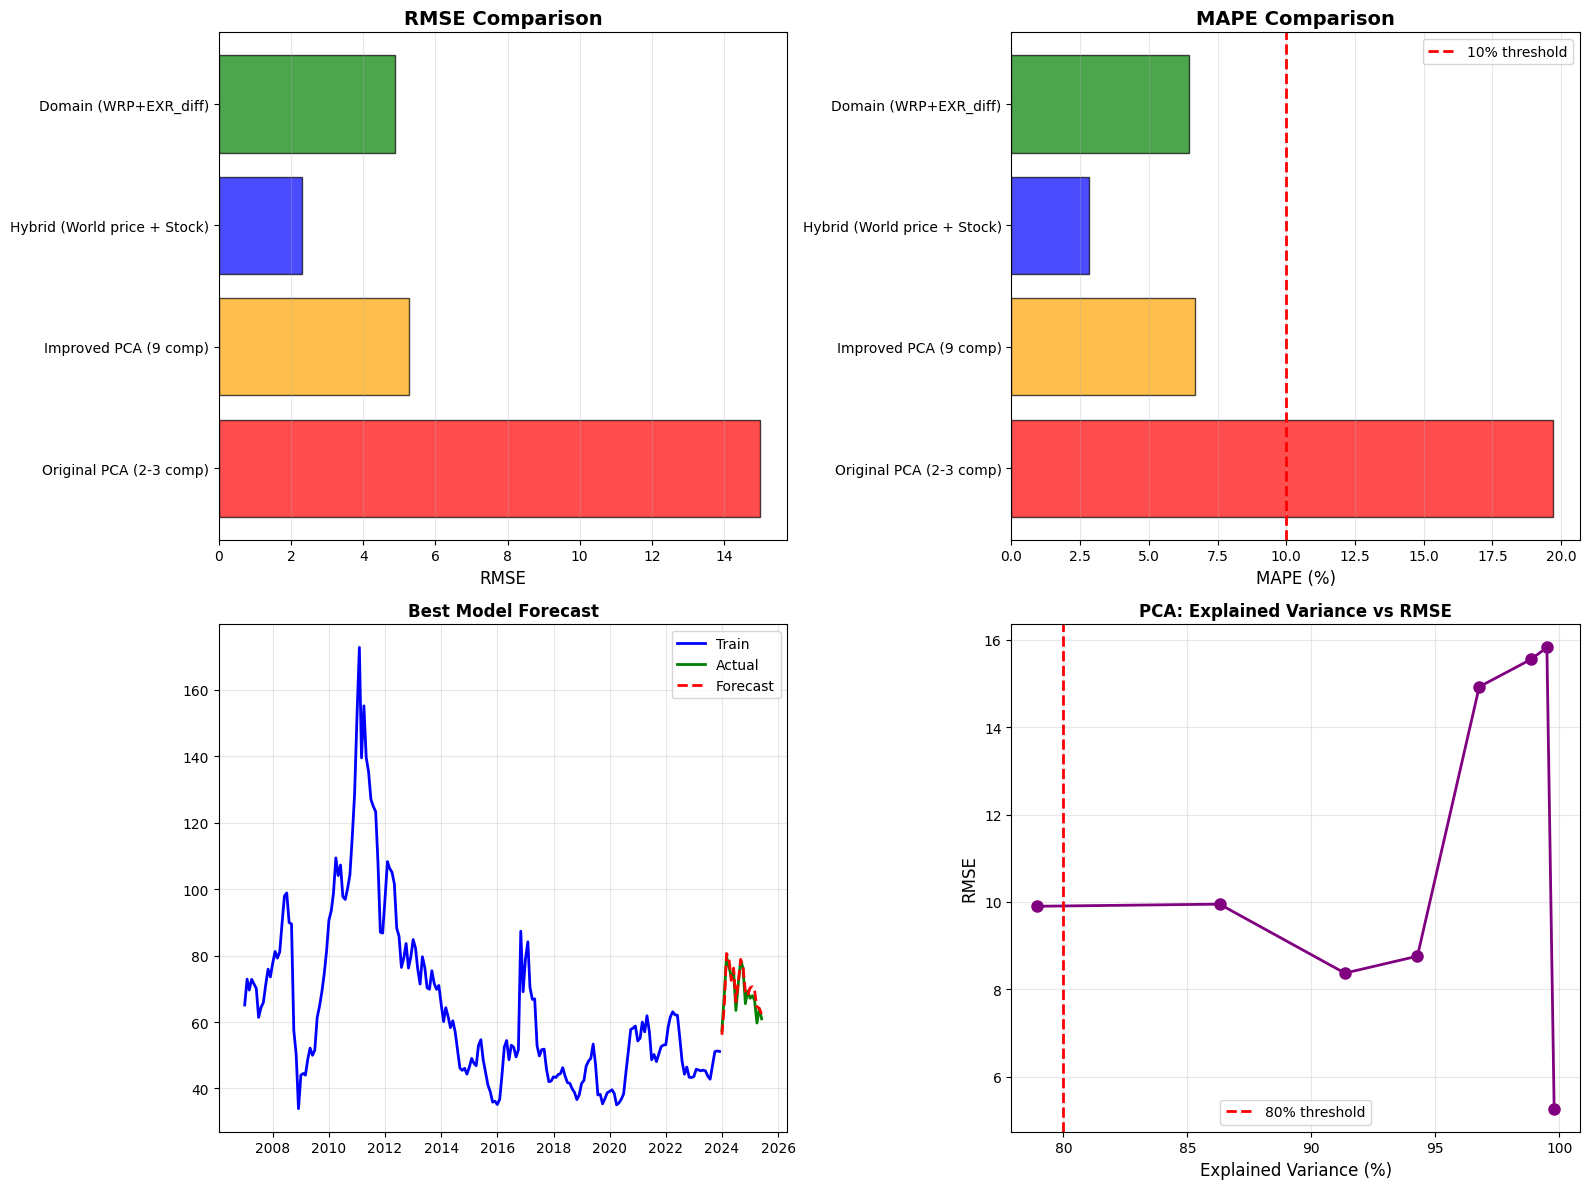

In [55]:
# %% [markdown]
# Auto Arima with PCA

# %%
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

TARGET_COL = 'thai_price'   # ถ้าใช้คอลัมน์ชื่ออื่น เช่น 'thai_price' ก็เปลี่ยนตรงนี้

# ใช้ชื่อคอลัมน์ external factors ชุดใหม่
external_factors = [
    'world_price_thb_kg', 'thai_price_ma6', 'world_price_thb_kg_ma6',
    'thai_price_ma12', 'world_price_thb_kg_ma12', 'thai_price_lag6',
    'world_price_thb_kg_lag6', 'china_pmi_ma12', 'china_pmi_ma6',
    'oil_price_thb', 'thai_price_lag12', 'world_price_thb_kg_lag12',
    'stock_lag6', 'stock_lag12'
]

print("Available factors in df:", df.columns.tolist())
print("Selected factors:", [f for f in external_factors if f in df.columns])
print()

# ---------- เตรียม exogenous variables ----------
train_exog_raw = train_data[external_factors].copy()
test_exog_raw  = test_data[external_factors].copy()

# แก้ inf -> NaN แล้วทำ mask เอาเฉพาะแถวที่ exog และ y ไม่ NaN
train_exog = train_exog_raw.replace([np.inf, -np.inf], np.nan)
test_exog  = test_exog_raw.replace([np.inf, -np.inf], np.nan)

mask_train = train_exog.notna().all(axis=1) & train_data[TARGET_COL].notna()
mask_test  = test_exog.notna().all(axis=1) & test_data[TARGET_COL].notna()

train_exog = train_exog.loc[mask_train]
test_exog  = test_exog.loc[mask_test]

y_train = train_data.loc[mask_train, TARGET_COL]
y_test  = test_data.loc[mask_test, TARGET_COL]

print(f"Train exogenous shape (clean): {train_exog.shape}")
print(f"Test exogenous shape  (clean): {test_exog.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape : {y_test.shape}\n")

# ---------- Standardize ก่อนทำ PCA ----------
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_exog)
test_scaled  = scaler.transform(test_exog)

print("\nFinding Optimal PCA Components")
approach1_results = []

for n_comp in range(2, 10):
    pca = PCA(n_components=n_comp)
    train_pca = pd.DataFrame(
        pca.fit_transform(train_scaled),
        index=y_train.index,   # align กับ y_train
        columns=[f'PC{i+1}' for i in range(n_comp)]
    )
    test_pca = pd.DataFrame(
        pca.transform(test_scaled),
        index=y_test.index,    # align กับ y_test
        columns=[f'PC{i+1}' for i in range(n_comp)]
    )
    
    explained_var = float(pca.explained_variance_ratio_.sum())
    print(f"\n{n_comp} Components: Explained Variance = {explained_var*100:.2f}%")
    
    try:
        model_auto = auto_arima(
            y_train, exogenous=train_pca,
            start_p=0, start_q=0,
            max_p=2, max_q=2,
            m=12,
            start_P=0,
            max_P=2, max_Q=2,
            d=1, D=1,
            seasonal=True,
            stepwise=True,
            suppress_warnings=True,
            trace=False,
            maxiter=200
        )
        
        sarimax_fit = SARIMAX(
            y_train,
            exog=train_pca,
            order=model_auto.order,
            seasonal_order=model_auto.seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        
        pred_mean = sarimax_fit.get_prediction(
            start=y_test.index[0], 
            end=y_test.index[-1],
            exog=test_pca, 
            dynamic=False
        ).predicted_mean
        
        rmse = np.sqrt(mean_squared_error(y_test, pred_mean))
        mape = mean_absolute_percentage_error(y_test, pred_mean) * 100
        
        approach1_results.append({
            'n_components': n_comp,
            'explained_var': explained_var,
            'RMSE': rmse,
            'MAPE': mape,
            'AIC': sarimax_fit.aic,
            'model': sarimax_fit,
            'pred': pred_mean
        })
        
        print(f"  RMSE: {rmse:.4f}, MAPE: {mape:.2f}%, AIC: {sarimax_fit.aic:.2f}")
        
    except Exception as e:
        print(f"Error: {str(e)[:80]}")

print("\nSummary (PCA only):")
if approach1_results:
    results1_df = pd.DataFrame([
        {
            'Components': r['n_components'],
            'Explained Var': f"{r['explained_var']*100:.1f}%",
            'RMSE': r['RMSE'],
            'MAPE': f"{r['MAPE']:.2f}%",
            'AIC': r['AIC']
        }
        for r in approach1_results
    ])
    print(results1_df.to_string(index=False))

    best1 = min(approach1_results, key=lambda x: x['RMSE'])
    print(f"\nBest PCA-only: {best1['n_components']} components")
    print(f"Explained Variance: {best1['explained_var']*100:.2f}%")
    print(f"RMSE: {best1['RMSE']:.4f}")
    print(f"MAPE: {best1['MAPE']:.2f}%")
else:
    best1 = None
    print("No valid results for approach 1 (PCA).")

# ---------------- Hybrid Approach (Key Factors + PCA) ----------------
print("\n\nHybrid Approach (Key Factors + PCA)")

# เลือก key factors จากชุด factor ใหม่ (เปลี่ยนชื่อให้ตรงกับคอลัมน์จริง)
key_factor_combinations = [
    (['world_price_thb_kg'], 'World price only'),
    (['world_price_thb_kg', 'oil_price_thb'], 'World price + Oil'),
    (['world_price_thb_kg', 'stock_lag6'], 'World price + Stock'),
    (['world_price_thb_kg', 'oil_price_thb', 'stock_lag6'], 'World + Oil + Stock')
]

approach2_results = []

for key_factors, name in key_factor_combinations:
    # ข้าม combination ที่ factor ไม่ครบในข้อมูล
    missing = [f for f in key_factors if f not in train_exog.columns]
    if missing:
        print(f"\nSkipping {name} (missing columns: {missing})")
        continue

    print(f"\nTesting: {name}")
    print(f"Key factors: {key_factors}")
    
    other_factors = [f for f in external_factors if f not in key_factors]
    print(f"PCA factors: {other_factors}")
    
    if len(other_factors) == 0:
        print("No remaining factors for PCA, skipping.")
        continue
    
    other_scaled      = scaler.fit_transform(train_exog[other_factors])
    other_scaled_test = scaler.transform(test_exog[other_factors])
    
    for n_pca in [2, 3, 4]:
        if n_pca > len(other_factors):
            continue
            
        pca = PCA(n_components=n_pca)
        other_pca      = pca.fit_transform(other_scaled)
        other_pca_test = pca.transform(other_scaled_test)
        
        train_hybrid = pd.DataFrame(index=y_train.index)
        test_hybrid  = pd.DataFrame(index=y_test.index)
        
        # ใส่ key factors ตรง ๆ
        for kf in key_factors:
            train_hybrid[kf] = train_exog[kf].values
            test_hybrid[kf]  = test_exog[kf].values
        
        # ใส่ PC จาก factor ที่เหลือ
        for i in range(n_pca):
            train_hybrid[f'PC{i+1}'] = other_pca[:, i]
            test_hybrid[f'PC{i+1}']  = other_pca_test[:, i]
        
        explained_var = float(pca.explained_variance_ratio_.sum())
        
        try:
            model_auto = auto_arima(
                y_train, exogenous=train_hybrid,
                start_p=0, start_q=0, max_p=2, max_q=2,
                m=12, start_P=0, max_P=2, max_Q=2,
                d=1, D=1, seasonal=True, stepwise=True,
                suppress_warnings=True, trace=False
            )
            
            sarimax_fit = SARIMAX(
                y_train, exog=train_hybrid,
                order=model_auto.order, seasonal_order=model_auto.seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False
            ).fit(disp=False)
            
            pred_mean = sarimax_fit.get_prediction(
                start=y_test.index[0], end=y_test.index[-1],
                exog=test_hybrid, dynamic=False
            ).predicted_mean
            
            rmse = np.sqrt(mean_squared_error(y_test, pred_mean))
            mape = mean_absolute_percentage_error(y_test, pred_mean) * 100
            
            approach2_results.append({
                'name': name,
                'key_factors': key_factors,
                'n_pca': n_pca,
                'total_features': len(key_factors) + n_pca,
                'explained_var_pca': explained_var,
                'RMSE': rmse,
                'MAPE': mape,
                'AIC': sarimax_fit.aic,
                'model': sarimax_fit,
                'pred': pred_mean
            })
            
            print(f"{len(key_factors)} key + {n_pca} PCA = {len(key_factors)+n_pca} total")
            print(f"PCA explains {explained_var*100:.1f}% of other factors")
            print(f"RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
            
        except Exception as e:
            print(f"Error: {str(e)[:60]}")

print("\nSummary (Hybrid):")
if approach2_results:
    results2_df = pd.DataFrame([
        {
            'Strategy': r['name'],
            'Total Feat': r['total_features'],
            'RMSE': r['RMSE'],
            'MAPE': f"{r['MAPE']:.2f}%",
            'AIC': r['AIC']
        }
        for r in approach2_results
    ])
    print(results2_df.to_string(index=False))

    best2 = min(approach2_results, key=lambda x: x['RMSE'])
    print("\nBest Hybrid:")
    print(f"Strategy: {best2['name']}")
    print(f"Key factors: {best2['key_factors']}")
    print(f"PCA components: {best2['n_pca']}")
    print(f"Total features: {best2['total_features']}")
    print(f"RMSE: {best2['RMSE']:.4f}")
    print(f"MAPE: {best2['MAPE']:.2f}%")
else:
    best2 = None
    print("No valid results for hybrid approach.")

# ---------------- รวมผลทุกวิธีไว้ดูเปรียบเทียบ ----------------
print("\nFINAL COMPARISON")

all_approaches = [
    {'Method': 'Original PCA (2-3 comp)', 'RMSE': 15.0063, 'MAPE': 19.70, 'Note': 'Your current result'}
]

if best1 is not None:
    all_approaches.append({
        'Method': f'Improved PCA ({best1["n_components"]} comp)',
        'RMSE': best1['RMSE'],
        'MAPE': best1['MAPE'],
        'Note': f'Explained {best1["explained_var"]*100:.1f}%'
    })
else:
    all_approaches.append({
        'Method': 'Improved PCA', 'RMSE': None, 'MAPE': None, 'Note': 'No valid result'
    })

if best2 is not None:
    all_approaches.append({
        'Method': f'Hybrid ({best2["name"]})',
        'RMSE': best2['RMSE'],
        'MAPE': best2['MAPE'],
        'Note': f'{best2["total_features"]} features total'
    })
else:
    all_approaches.append({
        'Method': 'Hybrid', 'RMSE': None, 'MAPE': None, 'Note': 'No valid result'
    })

# reference เดิม
all_approaches.append({
    'Method': 'Domain (WRP+EXR_diff)', 'RMSE': 4.88, 'MAPE': 6.48,
    'Note': 'Reference from before'
})

comparison_df = pd.DataFrame(all_approaches)
print(comparison_df.to_string(index=False))

# ---------------- Visualization ----------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

methods = [a['Method'] for a in all_approaches]
rmses   = [np.nan if a['RMSE'] is None else a['RMSE'] for a in all_approaches]
mapes   = [np.nan if a['MAPE'] is None else a['MAPE'] for a in all_approaches]
colors  = ['red', 'orange', 'blue', 'green']

# RMSE
ax = axes[0, 0]
ax.barh(methods, rmses, color=colors, edgecolor='black', alpha=0.7)
ax.set_xlabel('RMSE', fontsize=12)
ax.set_title('RMSE Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# MAPE
ax = axes[0, 1]
ax.barh(methods, mapes, color=colors, edgecolor='black', alpha=0.7)
ax.axvline(x=10, color='red', linestyle='--', label='10% threshold', linewidth=2)
ax.set_xlabel('MAPE (%)', fontsize=12)
ax.set_title('MAPE Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# Best forecast
ax = axes[1, 0]
best_overall = None
if best1 is not None and best2 is not None:
    best_overall = best2 if best2['RMSE'] < best1['RMSE'] else best1
elif best1 is not None:
    best_overall = best1
elif best2 is not None:
    best_overall = best2

ax.plot(y_train.index, y_train.values, label='Train', color='blue', linewidth=2)
ax.plot(y_test.index, y_test.values, label='Actual', color='green', linewidth=2)
if best_overall is not None and 'pred' in best_overall:
    ax.plot(y_test.index, best_overall['pred'], label='Forecast', 
            color='red', linewidth=2, linestyle='--')
else:
    ax.text(0.5, 0.5, 'No valid forecast', transform=ax.transAxes, 
            fontsize=14, color='red', ha='center', va='center')
ax.set_title('Best Model Forecast', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Explained variance vs RMSE (เฉพาะ PCA-only)
ax = axes[1, 1]
if approach1_results:
    exp_vars   = [r['explained_var']*100 for r in approach1_results]
    rmses_pca  = [r['RMSE'] for r in approach1_results]
    ax.plot(exp_vars, rmses_pca, 'o-', linewidth=2, markersize=8, color='purple')
    ax.set_xlabel('Explained Variance (%)', fontsize=12)
    ax.set_ylabel('RMSE', fontsize=12)
    ax.set_title('PCA: Explained Variance vs RMSE', fontsize=12, fontweight='bold')
    ax.axvline(x=80, color='red', linestyle='--', label='80% threshold', linewidth=2)
    ax.grid(True, alpha=0.3)
    ax.legend()
else:
    ax.text(0.5, 0.5, 'No PCA results', transform=ax.transAxes,
            fontsize=14, color='red', ha='center', va='center')
    ax.set_axis_off()

plt.tight_layout()
plt.show()


In [ ]:
# %% [markdown]
# Performance Comparison

# %%
data = {
    'Model': ['Baseline', 'Auto Arima Tuning'],
    'RMSE': [rmse_before, rmse_arima],
    'MAPE': [mape_before, mape_arima],
    'ACCURACY': [accuracy_before, accuracy_arima]
}
df_comparison = pd.DataFrame(data)

df_comparison['MAPE (%)'] = (df_comparison['MAPE'] * 100).map('{:.2f}%'.format)
df_comparison['ACCURACY (%)'] = (df_comparison['ACCURACY'] * 100).map('{:.2f}%'.format)

df_display = df_comparison[['Model', 'RMSE', 'MAPE (%)', 'ACCURACY (%)']]

print("Performance Comparison\n")
print(df_display.to_string(index=True, col_space=10))


NameError: name 'approach_pca_lstm' is not defined

In [63]:
print("=== BEFORE MODEL (Baseline SARIMAX)===")
print("RMSE : ",f"{rmse_before:.4f}")
print("MAPE : ",f"{mape_before*100:.2f}%\n")

=== BEFORE MODEL (Baseline SARIMAX)===
RMSE :  5.9539
MAPE :  6.89%



NameError: name 'pred_after_series' is not defined

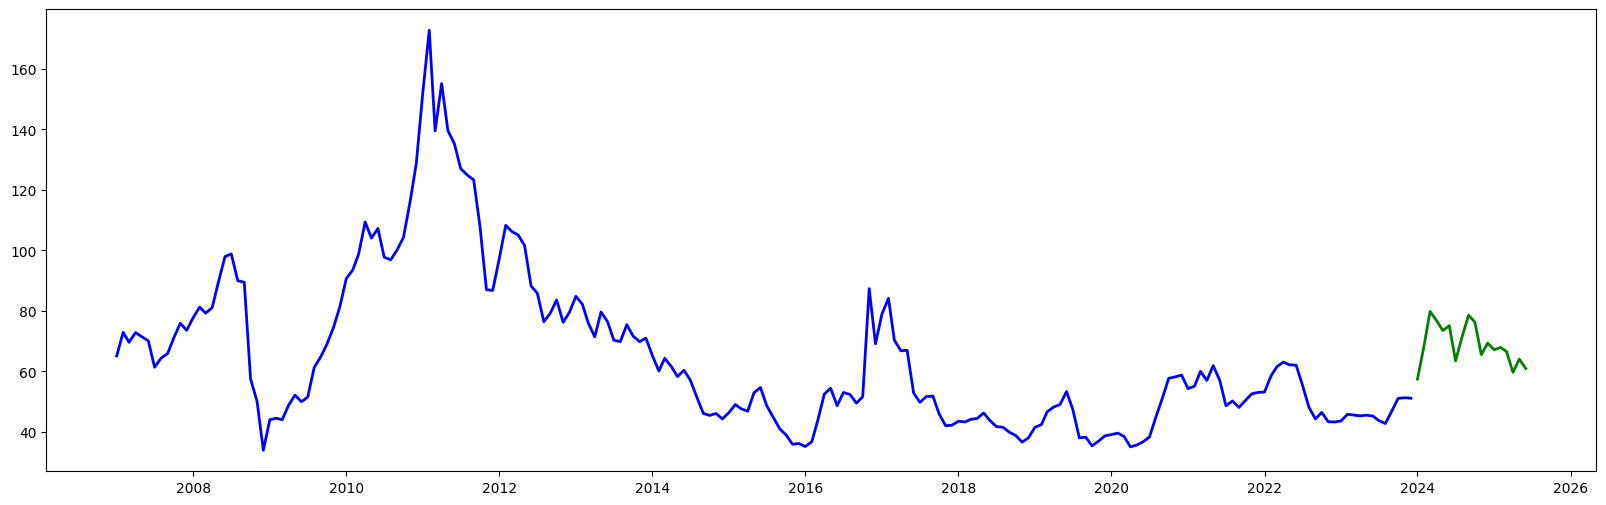

In [64]:
plt.figure(figsize=(20, 6))

# Train
plt.plot(train_data.index, train_data['thai_price'],
         label='Train', color='blue', linewidth=2)

# Actual
plt.plot(test_data.index, test_data['thai_price'],
         label='Actual (Test)', color='green', linewidth=2)

# Forecast
plt.plot(pred_after_series.index, pred_after_series.values,
         label='Forecast (Ridge)', color='orange',
         linestyle='--', linewidth=2)

plt.title('Thai Rubber Price Forecast (Train / Actual / Ridge)', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price (thai_price)')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()
